Here we look at the results of the DNAseq data for the penicillin-adapted populations. Assuming the scripts `variant_calling_DNA.sh` and `variant_calling_DNA_earlier_timepoints.sh` have already been run, we will first get the positions of the mutations that appear in the PEN-adapted population (and don't appear in the no drug control populations), then go through the vcf of each population to get the variant stats for those particular mutations. 

In [50]:
import pandas as pd
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
dnaseq_muts_file = 'data/vars/variant_calling_PEN_PRJNA856279/adapted_unique/All_pops_merged_with_gene_context.tsv'
mutations_dnaseq = pd.read_csv(dnaseq_muts_file, sep='\t', header=None)
dnaseq_coordinates = list(mutations_dnaseq[2])

In [2]:
mutations_rnaseq = pd.read_csv('data/T4_adapted_all_mutations.csv')
mutations_rnaseq[mutations_rnaseq.ABX=='PEN']
rnaseq_coordinates = list(mutations_rnaseq[mutations_rnaseq.ABX=='PEN']['end'])

In [3]:
def parse_vcf_line(line):
    """Parse a single VCF line and extract key information"""
    if line.startswith('#'):
        return None
    
    fields = line.strip().split('\t')
    chrom = fields[0]
    pos = int(fields[1])
    ref = fields[3]
    alt = fields[4]
    qual = fields[5]
    info = fields[7]
    format_field = fields[8]
    sample = fields[9]
    
    # Parse INFO field
    info_dict = {}
    for item in info.split(';'):
        if '=' in item:
            key, value = item.split('=', 1)
            info_dict[key] = value
    
    # Parse DP4 (ref forward, ref reverse, alt forward, alt reverse)
    dp4 = info_dict.get('DP4', '0,0,0,0')
    ref_fwd, ref_rev, alt_fwd, alt_rev = map(int, dp4.split(','))
    ref_depth = ref_fwd + ref_rev
    alt_depth = alt_fwd + alt_rev
    total_depth = ref_depth + alt_depth
    
    # Calculate allele frequency
    alt_freq = alt_depth / total_depth if total_depth > 0 else 0
    
    # Parse sample field (GT:PL:DP:SP:AD)
    sample_values = sample.split(':')
    sample_dict = dict(zip(format_field.split(':'), sample_values))
    
    return {
        'chrom': chrom,
        'pos': pos,
        'ref': ref,
        'alt': alt,
        'qual': float(qual) if qual != '.' else None,
        'total_depth': total_depth,
        'ref_depth': ref_depth,
        'alt_depth': alt_depth,
        'alt_freq': alt_freq,
        'genotype': sample_dict.get('GT', '.'),
        'AD': sample_dict.get('AD', '.')
    }

def extract_variants_at_positions(vcf_file, positions):
    """
    Extract variant information for specific positions from a VCF file
    
    Args:
        vcf_file: Path to VCF file
        positions: List of positions to extract (can be list of ints or list of tuples (chrom, pos))
    
    Returns:
        DataFrame with variant information
    """
    results = []
    
    # Convert positions to set for fast lookup
    if isinstance(positions[0], int):
        pos_set = set(positions)
        check_chrom = False
    else:
        pos_set = set(positions)  # set of (chrom, pos) tuples
        check_chrom = True
    
    with open(vcf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            
            parsed = parse_vcf_line(line)
            if parsed is None:
                continue
            
            # Check if this position is in our list
            if check_chrom:
                if (parsed['chrom'], parsed['pos']) in pos_set:
                    results.append(parsed)
            else:
                if parsed['pos'] in pos_set:
                    results.append(parsed)
    
    return pd.DataFrame(results)

In [12]:
pen_sample_names = ['T4PenD32pop1_calls',
                   'T4PenD32pop2_calls',
                   'T4PenD32pop3_calls',
                   'T4PenD32pop4_calls',
                    'T4PenD21pop1_calls',
                   'T4PenD21pop2_calls',
                   'T4PenD21pop3_calls',
                   'T4PenD21pop4_calls',
                    'T4PenD14pop1_calls',
                   'T4PenD14pop2_calls',
                   'T4PenD14pop3_calls',
                   'T4PenD14pop4_calls',
                    'T4PenD7pop1_calls',
                   'T4PenD7pop2_calls',
                   'T4PenD7pop3_calls',
                   'T4PenD7pop4_calls',
                   ]

all_mutation_data = pd.DataFrame()
for adapted_population in pen_sample_names: 
    vcf_filename = f'data/vars/variant_calling_PEN_PRJNA856279/{adapted_population}.vcf'
    mutation_data_for_pop = extract_variants_at_positions(vcf_filename,
                             dnaseq_coordinates)
    mutation_data_for_pop['sample']  = adapted_population.split('_')[0]
    all_mutation_data = pd.concat([all_mutation_data, mutation_data_for_pop])

all_mutation_data.head()

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample
0,NZ_CP155539.1,38578,C,A,225.0070,107,0,107,1.000000,1,"0,107",T4PenD32pop1
1,NZ_CP155539.1,188060,A,G,156.0060,19,0,19,1.000000,1,"0,19",T4PenD32pop1
2,NZ_CP155539.1,347083,CAAAAAAA,CAAAAAA,217.4690,58,2,56,0.965517,1,"2,56",T4PenD32pop1
3,NZ_CP155539.1,470939,AATATATATATATATATATA,AATATATATATATATATATATA,97.4672,6,1,5,0.833333,1,"1,5",T4PenD32pop1
4,NZ_CP155539.1,713638,C,A,225.0070,56,0,56,1.000000,1,"0,56",T4PenD32pop1


In [13]:
# add the annotations for the mutations
all_mutation_data_annot = all_mutation_data.merge(mutations_rnaseq[mutations_rnaseq.ABX=='PEN'][['end', 
                                                                       'gene_start', 'gene_end', 
                                                                       'strand',
                                                                       'gene',
                                                                       'locus_tag',
                                                                       'AA change'
                                                                      ]],
                       left_on='pos', right_on='end')

In [14]:
all_mutation_data_annot.head()

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample,end,gene_start,gene_end,strand,gene,locus_tag,AA change
0,NZ_CP155539.1,38578,C,A,225.007,107,0,107,1.000000,1,"0,107",T4PenD32pop1,38578,36822.0,38795.0,+,NaN,ABC806_RS00205,A586E
1,NZ_CP155539.1,713638,C,A,225.007,56,0,56,1.000000,1,"0,56",T4PenD32pop1,713638,713480.0,714925.0,-,NaN,ABC806_RS03775,A430S
2,NZ_CP155539.1,876067,T,C,225.007,64,0,64,1.000000,1,"0,64",T4PenD32pop1,876067,875416.0,877140.0,+,NaN,ABC806_RS04600,F218L
3,NZ_CP155539.1,949275,CTTTTTTTT,CTTTTTTT,217.469,51,2,49,0.960784,1,"2,49",T4PenD32pop1,949275,948487.0,949296.0,-,NaN,ABC806_RS04990,Frameshift
4,NZ_CP155539.1,1832115,G,A,225.007,89,0,89,1.000000,1,"0,89",T4PenD32pop1,1832115,1831718.0,1832353.0,-,cps4E,ABC806_RS09395,P80L


In [15]:
# annotate metadata
all_mutation_data_annot['Population'] = all_mutation_data_annot.apply(
    lambda x: x['sample'][-1], 
    axis=1
)

def get_day_from_samplename(samplename):
    suffix = samplename.split('D')[1]
    day = suffix.split('pop')[0]
    return(day)
    
all_mutation_data_annot['Day'] = all_mutation_data_annot.apply(
    lambda x: get_day_from_samplename(x['sample']), 
    axis=1
)


# annotate mutations
all_mutation_data_annot['gene'] = all_mutation_data_annot['gene'].fillna(all_mutation_data_annot['locus_tag'])
all_mutation_data_annot['mutation_name'] = all_mutation_data_annot.apply(lambda x: x['gene'] + '\n' + x['AA change'].split(',')[0], axis=1)


In [32]:
all_mutation_data_annot[all_mutation_data_annot.gene=='pbp2X'][['']]

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,...,end,gene_start,gene_end,strand,gene,locus_tag,AA change,Population,Day,mutation_name
5,NZ_CP155539.1,1847707,T,G,225.0070,71,0,71,1.000000,1,...,1847707,1847211.0,1849463.0,-,pbp2X,ABC806_RS09465,Y586S,1,32,pbp2X\nY586S
11,NZ_CP155539.1,1847707,T,G,225.0070,79,0,79,1.000000,1,...,1847707,1847211.0,1849463.0,-,pbp2X,ABC806_RS09465,Y586S,2,32,pbp2X\nY586S
17,NZ_CP155539.1,1847707,T,G,225.0070,104,0,104,1.000000,1,...,1847707,1847211.0,1849463.0,-,pbp2X,ABC806_RS09465,Y586S,3,32,pbp2X\nY586S
23,NZ_CP155539.1,1847707,T,G,225.0070,146,0,146,1.000000,1,...,1847707,1847211.0,1849463.0,-,pbp2X,ABC806_RS09465,Y586S,4,32,pbp2X\nY586S
38,NZ_CP155539.1,1847707,T,G,82.0054,114,16,98,0.859649,1,...,1847707,1847211.0,1849463.0,-,pbp2X,ABC806_RS09465,Y586S,3,21,pbp2X\nY586S


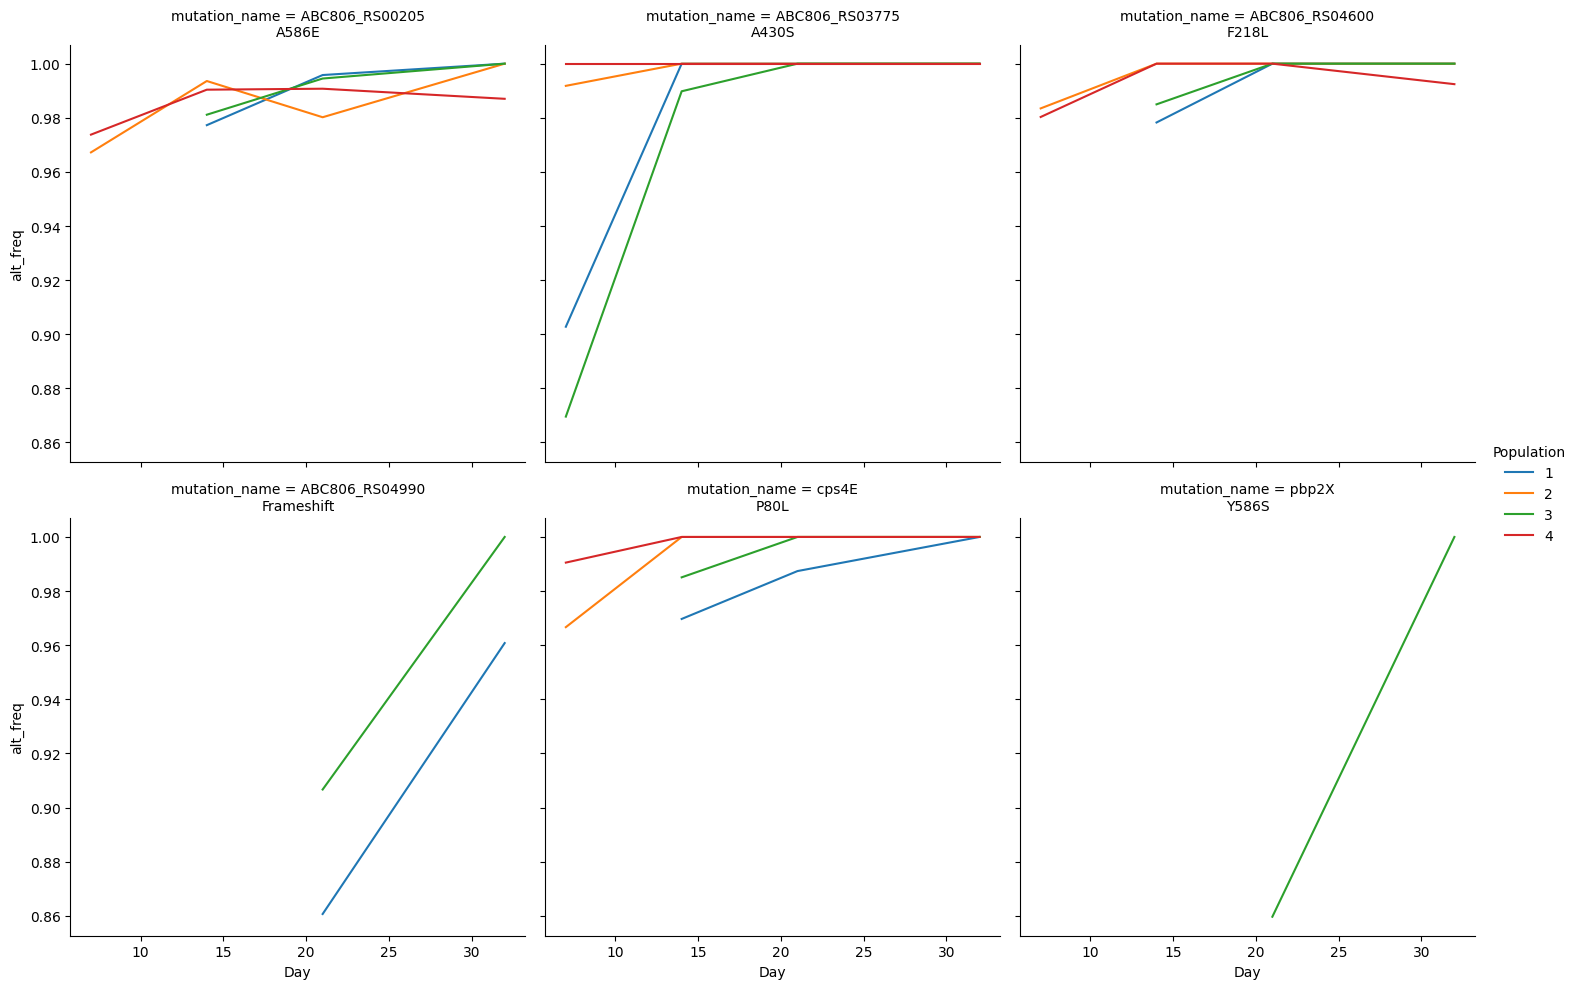

In [34]:
all_mutation_data_annot['Day'] = all_mutation_data_annot['Day'].astype(int)

sns.relplot(
    data=all_mutation_data_annot,
    x="Day", y="alt_freq", hue='Population', col='mutation_name',
    kind='line', 
    col_wrap=3
)
plt.ylabel('Alternative allele frequency')
plt.savefig('data/figures/PEN_mutations_DNAseq_all_timepoints.png',
           bbox_inches='tight')

/root/.cache/pypoetry/virtualenvs/entropy-5qUdb1eD-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/root/.cache/pypoetry/virtualenvs/entropy-5qUdb1eD-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/root/.cache/pypoetry/virtualenvs/entropy-5qUdb1eD-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/root/.cache/pypoetry/virtualenvs/entropy-5qUdb1eD-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0

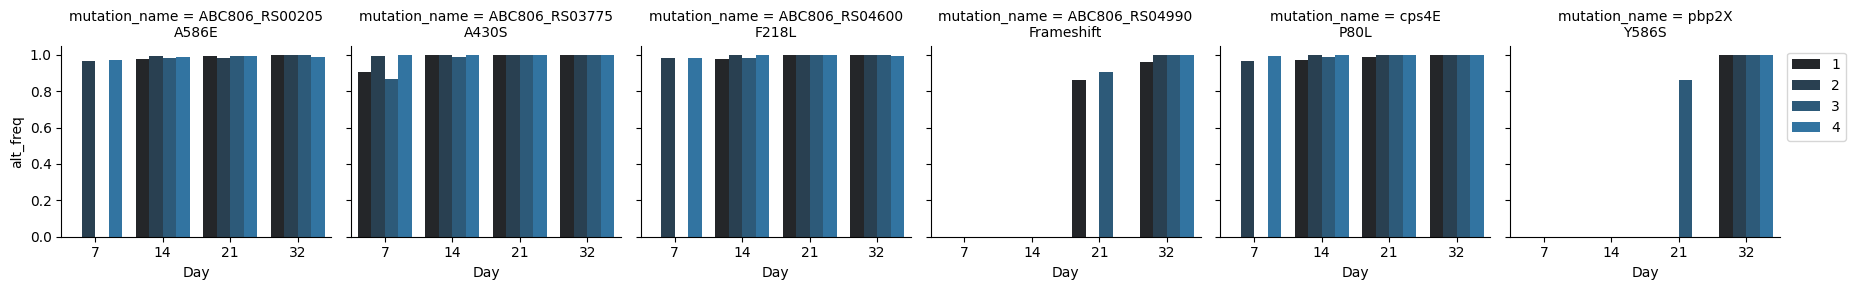

In [44]:
all_mutation_data_annot['Population'] = all_mutation_data_annot['Population'].astype(int)

g = sns.FacetGrid(all_mutation_data_annot, col='mutation_name')
g.map(sns.barplot, 'Day', 'alt_freq', 'Population')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('data/figures/PEN_mutations_DNAseq_alltime_bar.png',
           bbox_inches='tight')

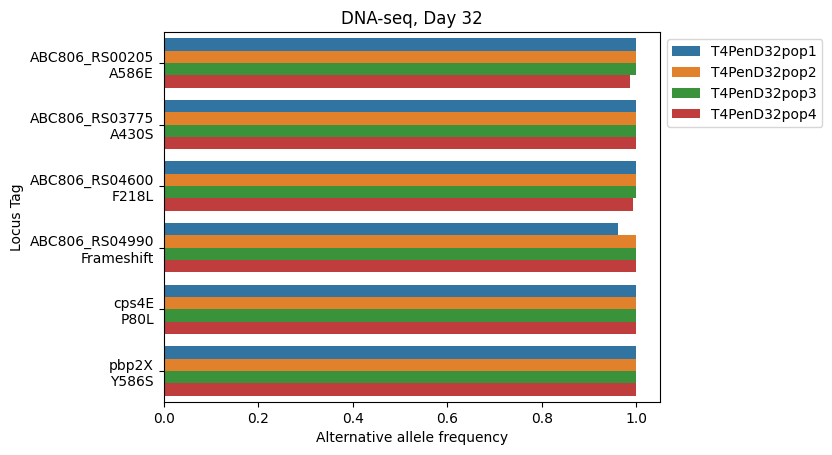

In [27]:
sns.barplot(data=all_mutation_data_annot[all_mutation_data_annot.Day==32], 
            y='mutation_name', x='alt_freq', hue='sample')
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('Alternative allele frequency')
plt.ylabel('Locus Tag')
plt.title('DNA-seq, Day 32')
plt.savefig('data/figures/PEN_mutations_DNAseq.png',
           bbox_inches='tight')

In [28]:
pen_sample_names_RNA = ['T4P-004PEN120min-A_calls',
                   'T4P-004PEN120min-B_calls',
                   'T4P-004PEN120min-C_calls',
                   ]
all_mutation_data_RNA = pd.DataFrame()
for adapted_population in pen_sample_names_RNA: 
    vcf_filename = f'data/vars/variant_calling_PEN/{adapted_population}.vcf'
    mutation_data_for_pop = extract_variants_at_positions(vcf_filename,
                             rnaseq_coordinates)
    mutation_data_for_pop['sample']  = adapted_population.split('_')[0]
    all_mutation_data_RNA = pd.concat([all_mutation_data_RNA, mutation_data_for_pop])

all_mutation_data_RNA

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample
0,NZ_CP155539.1,38578,C,A,225.0070,120,0,120,1.000000,1,"0,120",T4P-004PEN120min-A
1,NZ_CP155539.1,713638,C,A,173.0070,57,0,57,1.000000,1,"0,57",T4P-004PEN120min-A
2,NZ_CP155539.1,876067,T,C,161.0060,34,0,34,1.000000,1,"0,34",T4P-004PEN120min-A
3,NZ_CP155539.1,949275,CTTTTTTTT,CTTTTTTT,106.4670,25,0,25,1.000000,1,"0,25",T4P-004PEN120min-A
4,NZ_CP155539.1,1832115,G,A,225.0070,150,0,150,1.000000,1,"0,150",T4P-004PEN120min-A
5,NZ_CP155539.1,1847707,T,G,189.0070,83,0,83,1.000000,1,"0,83",T4P-004PEN120min-A
6,NZ_CP155539.1,2026742,G,"T,A",213.0070,29,0,29,1.000000,1,"0,28,1",T4P-004PEN120min-A
0,NZ_CP155539.1,38578,C,A,212.0070,130,1,129,0.992308,1,"1,129",T4P-004PEN120min-B
1,NZ_CP155539.1,701249,T,A,53.0050,7,1,6,0.857143,1,"1,5",T4P-004PEN120min-B
2,NZ_CP155539.1,713638,C,A,225.0070,77,0,77,1.000000,1,"0,77",T4P-004PEN120min-B


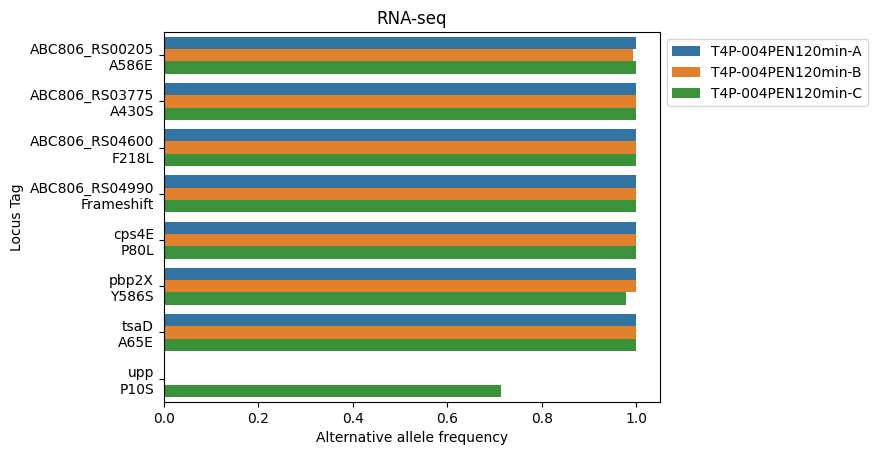

In [30]:
# add the annotations for the mutations
all_mutation_data_RNA_annot = all_mutation_data_RNA.merge(mutations_rnaseq[mutations_rnaseq.ABX=='PEN'][['end', 
                                                                       'gene_start', 'gene_end', 
                                                                       'strand',
                                                                       'gene',
                                                                       'locus_tag',
                                                                       'AA change'
                                                                      ]],
                       left_on='pos', right_on='end')

all_mutation_data_RNA_annot = all_mutation_data_RNA_annot[~all_mutation_data_RNA_annot.locus_tag.isna()]
all_mutation_data_RNA_annot['gene'] = all_mutation_data_RNA_annot['gene'].fillna(all_mutation_data_RNA_annot['locus_tag'])
all_mutation_data_RNA_annot['mutation_name'] = all_mutation_data_RNA_annot.apply(lambda x: x['gene'] + '\n' + x['AA change'].split(',')[0], axis=1)

sns.barplot(data=all_mutation_data_RNA_annot, y='mutation_name', x='alt_freq', hue='sample')
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('Alternative allele frequency')
plt.ylabel('Locus Tag')
plt.title('RNA-seq')
plt.savefig('data/figures/PEN_mutations_RNAseq.png',
           bbox_inches='tight')

In [71]:
abx_adapted_sample_names = {'PEN': ['data/vars/variant_calling_PEN/T4P-004PEN120min-A_calls.vcf',
                                   'data/vars/variant_calling_PEN/T4P-004PEN120min-B_calls.vcf',
                                   'data/vars/variant_calling_PEN/T4P-004PEN120min-C_calls.vcf'],
                            'CIP': ['data/vars/variant_calling_CIP/T4C-NDC120min-a_calls.vcf',
                                   'data/vars/variant_calling_CIP/T4C-NDC120min-b_calls.vcf',
                                   'data/vars/variant_calling_CIP/T4C-NDC120min-c_calls.vcf'],
                            'KAN': ['data/vars/variant_calling_KAN/T4K-1KAN120min-a_calls.vcf',
                                   'data/vars/variant_calling_KAN/T4K-1KAN120min-b_calls.vcf',
                                   'data/vars/variant_calling_KAN/T4K-1KAN120min-c_calls.vcf'],
                            'RIF': ['data/vars/variant_calling_RIF/T4R-0035RIF120min-A_calls.vcf',
                                   'data/vars/variant_calling_RIF/T4R-0035RIF120min-B_calls.vcf',
                                   'data/vars/variant_calling_RIF/T4R-0035RIF120min-C_calls.vcf'],
                            'VNC': ['data/vars/variant_calling_VNC/T4V-024V90MIN-A_calls.vcf',
                                   'data/vars/variant_calling_VNC/T4V-024V90MIN-B_calls.vcf',
                                   'data/vars/variant_calling_VNC/T4V-024V90MIN-C_calls.vcf'],
                           }


def plot_allele_freq_for_adapted(abx):
    # get the relevant coordinates
    rnaseq_coordinates_abx = list(mutations_rnaseq[mutations_rnaseq.ABX==abx]['end'])
    all_mutation_data_RNA = pd.DataFrame()
    abx_sample_names = abx_adapted_sample_names[abx]
    for adapted_population in abx_sample_names:
        sample_name_base = os.path.basename(adapted_population)
        sample_name = os.path.splitext(sample_name_base)[0]
        mutation_data_for_pop = extract_variants_at_positions(adapted_population,
                             rnaseq_coordinates_abx)
        mutation_data_for_pop['sample']  = sample_name.split('_')[0]
        all_mutation_data_RNA = pd.concat([all_mutation_data_RNA, mutation_data_for_pop])


    # add the annotations for the mutations
    all_mutation_data_RNA_annot = all_mutation_data_RNA.merge(mutations_rnaseq[mutations_rnaseq.ABX==abx][['end', 
                                                                           'gene_start', 'gene_end', 
                                                                           'strand',
                                                                           'gene',
                                                                           'locus_tag',
                                                                           'AA change'
                                                                          ]],
                           left_on='pos', right_on='end')

    all_mutation_data_RNA_annot = all_mutation_data_RNA_annot[~all_mutation_data_RNA_annot.locus_tag.isna()]
    all_mutation_data_RNA_annot['gene'] = all_mutation_data_RNA_annot['gene'].fillna(all_mutation_data_RNA_annot['locus_tag'])
    all_mutation_data_RNA_annot['AA change'] = all_mutation_data_RNA_annot['AA change'].fillna('')

    all_mutation_data_RNA_annot['mutation_name'] = all_mutation_data_RNA_annot.apply(lambda x: x['gene'] + '\n' + x['AA change'].split(',')[0], axis=1)
    
    sns.barplot(data=all_mutation_data_RNA_annot, y='mutation_name', x='alt_freq', hue='sample')
    plt.legend(bbox_to_anchor = (1,1))
    plt.xlabel('Alternative allele frequency')
    plt.ylabel('Mutation')
    plt.title(f'RNA-seq; {abx}')
    plt.savefig(f'data/figures/{abx}_mutations_RNAseq.png',
           bbox_inches='tight')
    
    return(all_mutation_data_RNA)

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample
0,NZ_CP155539.1,38578,C,A,225.0070,120,0,120,1.000000,1,"0,120",T4P-004PEN120min-A
1,NZ_CP155539.1,713638,C,A,173.0070,57,0,57,1.000000,1,"0,57",T4P-004PEN120min-A
2,NZ_CP155539.1,876067,T,C,161.0060,34,0,34,1.000000,1,"0,34",T4P-004PEN120min-A
3,NZ_CP155539.1,949275,CTTTTTTTT,CTTTTTTT,106.4670,25,0,25,1.000000,1,"0,25",T4P-004PEN120min-A
4,NZ_CP155539.1,1832115,G,A,225.0070,150,0,150,1.000000,1,"0,150",T4P-004PEN120min-A
5,NZ_CP155539.1,1847707,T,G,189.0070,83,0,83,1.000000,1,"0,83",T4P-004PEN120min-A
6,NZ_CP155539.1,2026742,G,"T,A",213.0070,29,0,29,1.000000,1,"0,28,1",T4P-004PEN120min-A
0,NZ_CP155539.1,38578,C,A,212.0070,130,1,129,0.992308,1,"1,129",T4P-004PEN120min-B
1,NZ_CP155539.1,701249,T,A,53.0050,7,1,6,0.857143,1,"1,5",T4P-004PEN120min-B
2,NZ_CP155539.1,713638,C,A,225.0070,77,0,77,1.000000,1,"0,77",T4P-004PEN120min-B


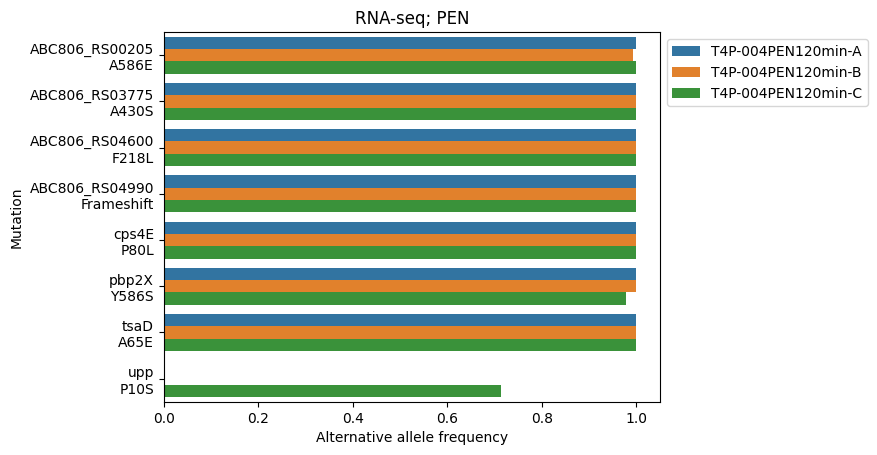

In [72]:
plot_allele_freq_for_adapted('PEN')

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample
0,NZ_CP155539.1,54633,C,A,225.0070,215,21,194,0.902326,1,"21,193",T4K-1KAN120min-a
1,NZ_CP155539.1,293352,A,G,103.0060,6,0,6,1.000000,1,"0,6",T4K-1KAN120min-a
2,NZ_CP155539.1,347083,CAAAAAAA,CAAAAAA,134.4680,14,0,14,1.000000,1,"0,14",T4K-1KAN120min-a
3,NZ_CP155539.1,410049,A,C,127.0060,106,8,98,0.924528,1,"8,98",T4K-1KAN120min-a
4,NZ_CP155539.1,648148,T,C,214.0070,49,0,49,1.000000,1,"0,49",T4K-1KAN120min-a
5,NZ_CP155539.1,713638,C,A,158.0060,35,3,32,0.914286,1,"3,32",T4K-1KAN120min-a
6,NZ_CP155539.1,1040716,T,C,31.0082,11,3,8,0.727273,1,"3,8",T4K-1KAN120min-a
7,NZ_CP155539.1,1403008,T,G,225.0070,167,6,161,0.964072,1,"6,161",T4K-1KAN120min-a
8,NZ_CP155539.1,1955004,C,T,186.0070,2376,245,2131,0.896886,1,"245,2126",T4K-1KAN120min-a
9,NZ_CP155539.1,2026742,G,"T,A",210.0070,81,0,81,1.000000,1,"0,80,1",T4K-1KAN120min-a


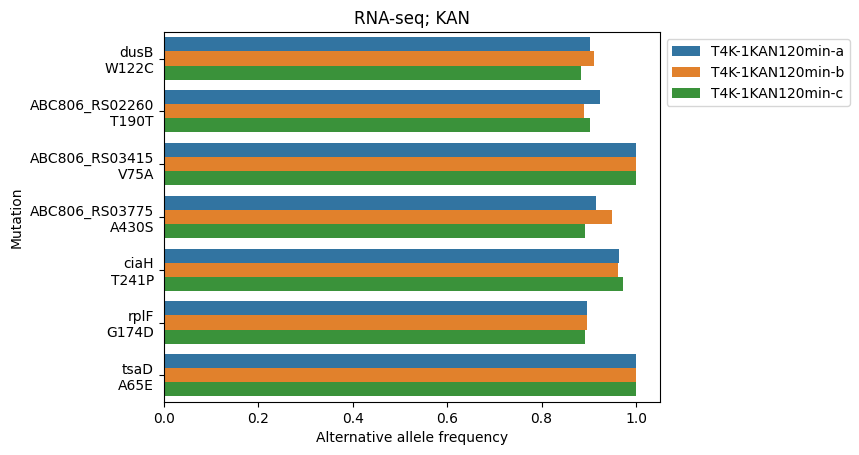

In [73]:
plot_allele_freq_for_adapted('KAN')

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample
0,NZ_CP155539.1,605909,C,"A,T",63.00510,31,4,27,0.870968,1,"4,18,9",T4C-NDC120min-a
1,NZ_CP155539.1,713638,C,A,35.00620,84,24,60,0.714286,1,"24,60",T4C-NDC120min-a
2,NZ_CP155539.1,759930,T,"A,C",69.00520,5,0,5,1.000000,1,"0,4,1",T4C-NDC120min-a
3,NZ_CP155539.1,928586,T,C,95.00560,16,2,14,0.875000,1,"2,13",T4C-NDC120min-a
4,NZ_CP155539.1,1006734,C,"A,T",4.76730,57,12,45,0.789474,1,"12,26,19",T4C-NDC120min-a
5,NZ_CP155539.1,1355419,G,T,155.00600,54,1,53,0.981481,1,"1,53",T4C-NDC120min-a
6,NZ_CP155539.1,1412530,A,G,18.07280,9,3,6,0.666667,1,"3,6",T4C-NDC120min-a
7,NZ_CP155539.1,1651324,TAAAAAAAAA,"TAAAAAAAAAA,TAAAAAAAAAAA",24.48180,52,32,20,0.384615,1,"32,13,4",T4C-NDC120min-a
0,NZ_CP155539.1,30695,A,C,30.00910,5,1,4,0.800000,1,"1,4",T4C-NDC120min-b
1,NZ_CP155539.1,713638,C,A,5.45858,56,12,44,0.785714,1,"12,44",T4C-NDC120min-b


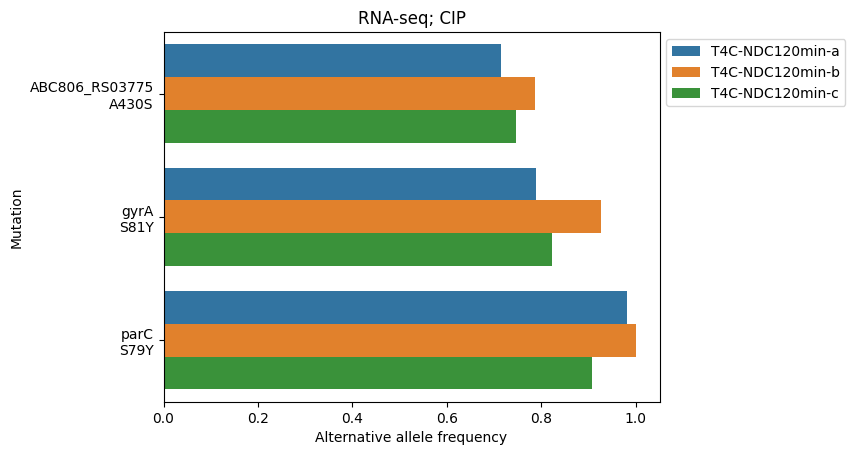

In [74]:
plot_allele_freq_for_adapted('CIP')

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample
0,NZ_CP155539.1,36739,T,TG,35.4676,19,11,8,0.421053,1,"11,8",T4R-0035RIF120min-A
1,NZ_CP155539.1,41081,G,A,45.0051,5,1,4,0.800000,1,"1,4",T4R-0035RIF120min-A
2,NZ_CP155539.1,295259,T,G,225.0070,770,0,770,1.000000,1,"0,769",T4R-0035RIF120min-A
3,NZ_CP155539.1,295434,C,G,225.0070,772,0,772,1.000000,1,"0,772",T4R-0035RIF120min-A
4,NZ_CP155539.1,1010780,T,A,94.0055,5,0,5,1.000000,1,"0,5",T4R-0035RIF120min-A
5,NZ_CP155539.1,1386841,CTTTTTTTTTT,CTTTTTTTTTTT,16.5631,80,46,34,0.425000,1,"46,20",T4R-0035RIF120min-A
6,NZ_CP155539.1,1500531,C,A,63.0051,45,6,39,0.866667,1,"6,39",T4R-0035RIF120min-A
7,NZ_CP155539.1,1651324,TAAAAAAAAA,TAAAAAAAAAA,39.4669,18,7,11,0.611111,1,"7,8",T4R-0035RIF120min-A
8,NZ_CP155539.1,2025767,T,C,16.1122,5,1,4,0.800000,1,"1,3",T4R-0035RIF120min-A
0,NZ_CP155539.1,8342,A,C,90.0055,6,0,6,1.000000,1,"0,6",T4R-0035RIF120min-B


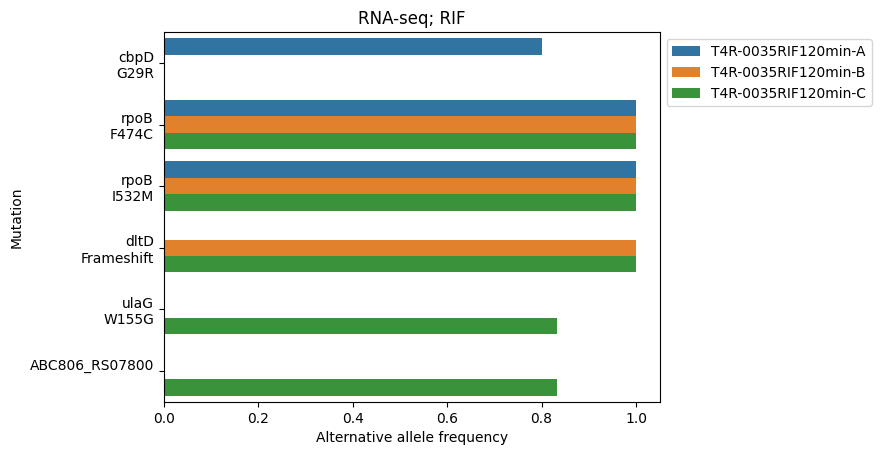

In [75]:
plot_allele_freq_for_adapted('RIF')

,chrom,pos,ref,alt,qual,total_depth,ref_depth,alt_depth,alt_freq,genotype,AD,sample
0,NZ_CP155539.1,668414,T,A,24.02190,6,2,4,0.666667,1,"2,4",T4V-024V90MIN-A
1,NZ_CP155539.1,716010,C,T,208.00700,39,0,39,1.000000,1,"0,39",T4V-024V90MIN-A
2,NZ_CP155539.1,1154962,C,T,158.00600,17,0,17,1.000000,1,"0,17",T4V-024V90MIN-A
3,NZ_CP155539.1,1334080,A,G,3.01251,509,207,302,0.593320,1,"207,292",T4V-024V90MIN-A
4,NZ_CP155539.1,1832037,G,A,171.00700,55,0,55,1.000000,1,"0,55",T4V-024V90MIN-A
5,NZ_CP155539.1,2026742,G,T,167.00600,46,0,46,1.000000,1,"0,46",T4V-024V90MIN-A
0,NZ_CP155539.1,716010,C,T,214.00700,42,0,42,1.000000,1,"0,42",T4V-024V90MIN-B
1,NZ_CP155539.1,1154962,C,"T,A",147.00600,14,0,14,1.000000,1,"0,13,1",T4V-024V90MIN-B
2,NZ_CP155539.1,1334080,A,G,46.00500,610,215,395,0.647541,1,"215,383",T4V-024V90MIN-B
3,NZ_CP155539.1,1832037,G,A,161.00600,28,0,28,1.000000,1,"0,28",T4V-024V90MIN-B


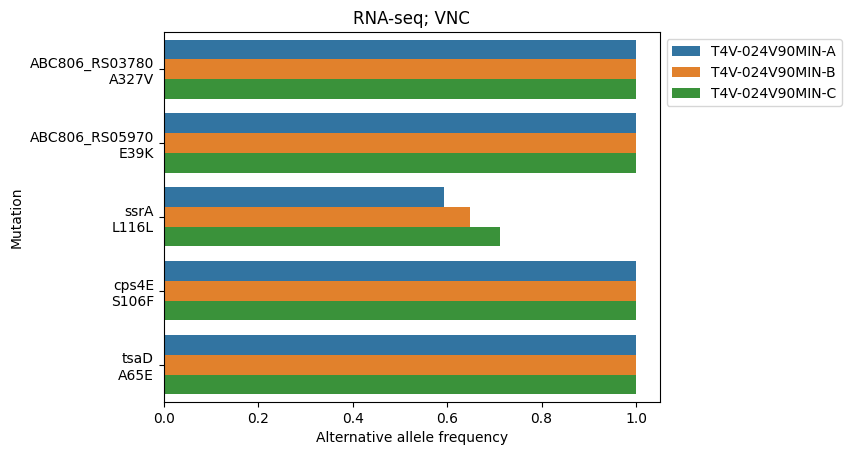

In [76]:
plot_allele_freq_for_adapted('VNC')